In [1]:
import numpy as np
from iminuit import Minuit
from classy import Class
import act_dr6_spt_lenslike as apslike

n_om = 100
om_min = .05
om_max = 1

n_s8 = 100
s8_min = 0.4
s8_max = 1.2

n_gamma = 100
gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

In [40]:
def chi2_lensing(cl_kk_theory, data_binned_clkk, binmat_act, cinv):
    model_binned = binmat_act @ cl_kk_theory
    residual = data_binned_clkk - model_binned
    return residual.T @ cinv @ residual

variant = 'act_baseline'
lens_only = False # use True if not combining with any primary CMB data
like_corrections = True # should be False if lens_only is True

data_dict = apslike.load_data(variant, lens_only=lens_only, like_corrections=like_corrections)

data = data_dict['data_binned_clkk']
binning_mat = data_dict['binmat_act']
cov_mat_inv = data_dict['cinv']

Loading ACT DR6 lensing likelihood v1.2...


In [37]:
# print(chi2_lensing(cl_kk_theory, data, binning_mat, cov_mat_inv))
data_dict.keys()

dict_keys(['include_planck', 'include_spt', 'include_spt_no_planck', 'likelihood_corrections', 'only_spt', 'full_data_binned_clkk_act', 'data_binned_clkk', 'full_binmat_act', 'binmat_act', 'bcents_act', 'full_act_cov', 'cov', 'cinv'])

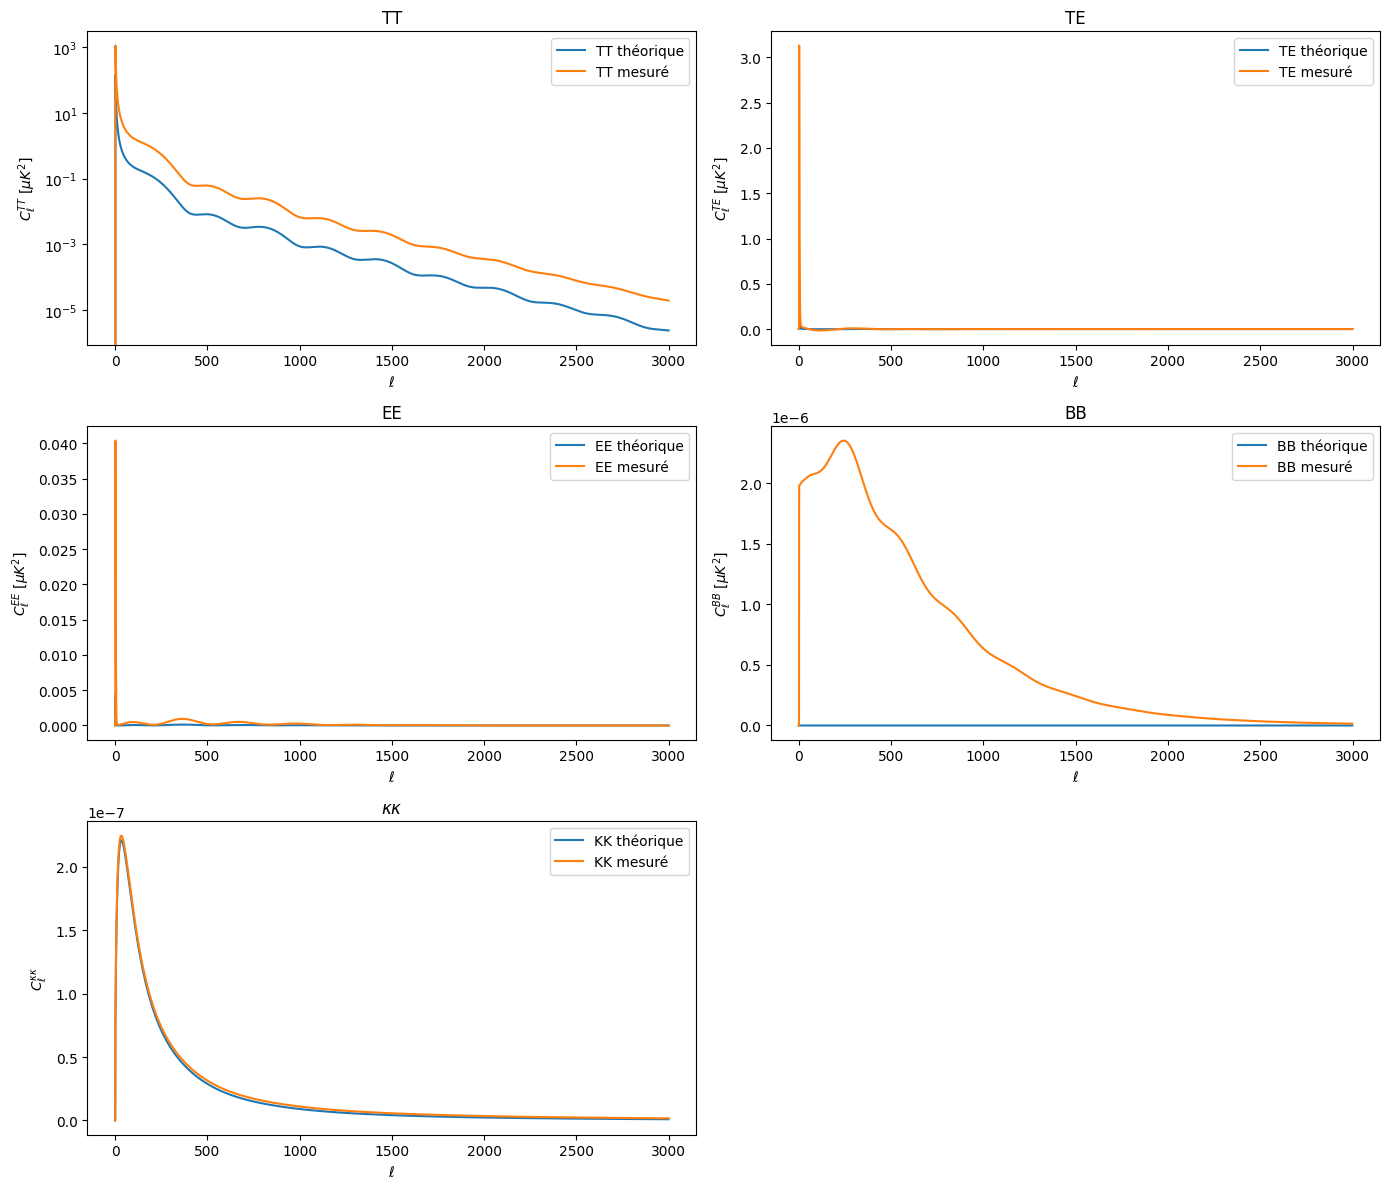

In [42]:
params = {
    'output': 'tCl,pCl,lCl',
    'l_max_scalars': 2999,       # Maximum multipole à calculer
    'h': 0.674,                  # H0/100
    'omega_b': 0.0224,           # Densité baryonique
    'omega_cdm': 0.120,          # Densité matière noire
    'A_s': 2.1e-9,               # Amplitude du spectre primordial
    'n_s': 0.965,                # Indice spectral
    'tau_reio': 0.054,           # Profondeur optique
}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

cl = cosmo.raw_cl()

ells = cl['ell']
cltt = cl['tt'] * 1e12      # K^2 -> μK^2
clte = cl['te'] * 1e12
clee = cl['ee'] * 1e12
clbb = cl['bb'] * 1e12

clphiphi = cl['pp']
clkk = (ells**2 * (ells+1)**2 / 4.) * clphiphi

fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# TT
axs[0, 0].plot(ells, cltt, label="TT théorique")
axs[0, 0].plot(ells, data_dict['fiducial_cl_tt'], label="TT mesuré")
axs[0, 0].set_xlabel(r'$\ell$')
axs[0, 0].set_ylabel(r'$C_\ell^{TT}$ [$\mu K^2$]')
axs[0, 0].set_title('TT')
axs[0, 0].set_yscale('log')
axs[0, 0].legend()

# TE
axs[0, 1].plot(ells, clte, label="TE théorique")
axs[0, 1].plot(ells, data_dict['fiducial_cl_te'], label="TE mesuré")
axs[0, 1].set_xlabel(r'$\ell$')
axs[0, 1].set_ylabel(r'$C_\ell^{TE}$ [$\mu K^2$]')
axs[0, 1].set_title('TE')
axs[0, 1].legend()

# EE
axs[1, 0].plot(ells, clee, label="EE théorique")
axs[1, 0].plot(ells, data_dict['fiducial_cl_ee'], label="EE mesuré")
axs[1, 0].set_xlabel(r'$\ell$')
axs[1, 0].set_ylabel(r'$C_\ell^{EE}$ [$\mu K^2$]')
axs[1, 0].set_title('EE')
axs[1, 0].legend()

# BB
axs[1, 1].plot(ells, clbb, label="BB théorique")
axs[1, 1].plot(ells, data_dict['fiducial_cl_bb'], label="BB mesuré")
axs[1, 1].set_xlabel(r'$\ell$')
axs[1, 1].set_ylabel(r'$C_\ell^{BB}$ [$\mu K^2$]')
axs[1, 1].set_title('BB')
axs[1, 1].legend()

# KK
axs[2, 0].plot(ells, clkk, label="KK théorique")
axs[2, 0].plot(ells, data_dict['fiducial_cl_kk'], label="KK mesuré")
axs[2, 0].set_xlabel(r'$\ell$')
axs[2, 0].set_ylabel(r'$C_\ell^{\kappa\kappa}$')
axs[2, 0].set_title(r'$\kappa\kappa$')
axs[2, 0].legend()

fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

cosmo.struct_cleanup()
cosmo.empty()

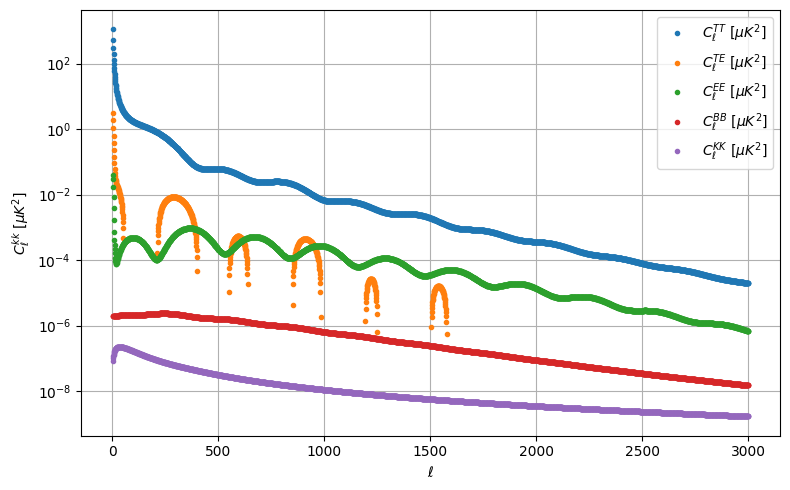

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def display_cl(cl, key):
    plt.errorbar(np.arange(len(cl)), cl, fmt='.', capsize=2, label=r"$C_\ell^{%s}$ [$\mu K^2$]" % key)

plt.figure(figsize=(8,5))
display_cl(data_dict['fiducial_cl_tt'], 'TT')
display_cl(data_dict['fiducial_cl_te'], 'TE')
display_cl(data_dict['fiducial_cl_ee'], 'EE')
display_cl(data_dict['fiducial_cl_bb'], 'BB')
display_cl(data_dict['fiducial_cl_kk'], 'KK')

plt.yscale('log')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell^{%s}$ [$\mu K^2$]" % "kk")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
